In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
filtered_cabbage_df = pd.read_csv("data-files/merged_df.csv")

In [87]:
filtered_cabbage_df.describe().round(2)

,단위_무게(kg),1kg_물량,1kg_평균가격,Year,Month,평균기온,평균풍속,평균강수량
count,20538.00,20538.00,20538.00,20538.00,20538.00,20538.00,20538.00,20538.00
mean,9.61,263517.83,689.21,2022.02,6.88,15.02,2.21,156.64
std,1.52,1630234.87,389.35,1.38,3.19,8.08,0.79,135.80
min,8.00,64.00,30.00,2020.00,1.00,-5.45,0.75,0.00
25%,8.00,9728.00,423.62,2021.00,5.00,8.28,1.60,53.20
50%,10.00,35775.00,601.05,2022.00,7.00,16.32,2.03,119.75
75%,10.00,121649.25,857.38,2023.00,10.00,22.11,2.62,225.64
max,15.00,51842752.00,7120.00,2024.00,12.00,28.99,4.34,706.06


# 신뢰구간으로 이상치 제거

In [88]:
# 80% 신뢰구간 (하위 10%, 상위 90%) 경계 계산
lower_bound = filtered_cabbage_df['1kg_평균가격'].quantile(0.10)
upper_bound = filtered_cabbage_df['1kg_평균가격'].quantile(0.90)

# 80% 신뢰구간 내의 데이터만 필터링
confidence_filtered_data_80 = filtered_cabbage_df[
    (filtered_cabbage_df['1kg_평균가격'] >= lower_bound) & 
    (filtered_cabbage_df['1kg_평균가격'] <= upper_bound)
]

# 90% 신뢰구간 (하위 5%, 상위 95%) 경계 계산
lower_bound_90 = filtered_cabbage_df['1kg_평균가격'].quantile(0.05)
upper_bound_90 = filtered_cabbage_df['1kg_평균가격'].quantile(0.95)

# 90% 신뢰구간 내의 데이터만 필터링
confidence_filtered_data_90 = filtered_cabbage_df[
    (filtered_cabbage_df['1kg_평균가격'] >= lower_bound_90) & 
    (filtered_cabbage_df['1kg_평균가격'] <= upper_bound_90)
]



In [89]:
# confidence_filtered_data_80.to_csv("data-files/filtered_90_percent_confidence.csv", index=False)

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# 재배 유형 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5, 6], "harvesting": [6, 7]},
    "가을재배": {"planting": [8, 9, 10], "harvesting": [10, 11]},
    "월동재배": {"planting": [10, 11], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [6, 7, 8], "harvesting": [9, 10]}
}

# 각 재배 유형에 대해 파종 및 수확 여부를 나타내는 열 추가
for cultivation, periods in cultivation_periods.items():
    confidence_filtered_data_80[cultivation] = (
        confidence_filtered_data_80['Month'].isin(periods['planting'] + periods['harvesting'])
    ).astype(int)

# '도매시장' 열 원-핫 인코딩 수행
filtered_data_80 = pd.get_dummies(confidence_filtered_data_80, columns=['도매시장'], prefix='Market')

# 피처(feature)와 타겟(target) 선택
features = [
    '1kg_물량', '평균기온', '평균풍속', '평균강수량'
] + list(cultivation_periods.keys()) + [col for col in filtered_data_80.columns if col.startswith('Market_')]
X = filtered_data_80[features]
y = filtered_data_80['1kg_평균가격']

# 결측값 처리: 결측값이 포함된 행 제거
X = X.dropna()
y = y.loc[X.index]

# 피처 스케일링: 데이터 정규화를 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 학습용(80%)과 테스트용(20%)으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



C:\Users\human\AppData\Local\Temp\ipykernel_10568\3401983799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_filtered_data_80[cultivation] = (
C:\Users\human\AppData\Local\Temp\ipykernel_10568\3401983799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_filtered_data_80[cultivation] = (
C:\Users\human\AppData\Local\Temp\ipykernel_10568\3401983799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# LinearRegression

In [91]:
# 랜덤 포레스트 모델 초기화 및 학습
lr_model = model_lr = LinearRegression()
lr_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = lr_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2



(np.float64(172.57796195174794),
 np.float64(43420.570307412665),
 np.float64(208.37603102903333),
 0.0897080022065927)

# 랜덤 포레스트

In [92]:
# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(135.57284800713052),
 np.float64(31374.526204213493),
 np.float64(177.12855840946003),
 0.34224769651679565)

In [93]:
target_mean = y.mean()

mae_ratio = mae / target_mean

target_mean, mae_ratio

(np.float64(639.8534303197723), np.float64(0.21188109898758659))

# XGBoost

In [94]:
from xgboost import XGBRegressor

# 랜덤 포레스트 모델 초기화 및 학습
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = xgb_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(134.71079403494997),
 np.float64(29620.55361554012),
 np.float64(172.10622770701855),
 0.3790189134887152)

# 이상치 제거를 로그 변환하여 제거

In [95]:
# 1차: 월별, 도매시장별, 산지-광역시도별로 IQR을 이용한 이상치 제거
def remove_outliers_iqr(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

# 그룹화하여 1차 이상치 제거
filtered_cabbage_df_no_outliers_1 = filtered_cabbage_df.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='1kg_평균가격')

# 2차: 로그 변환 적용 후 이상치 제거
filtered_cabbage_df_no_outliers_1['log_1kg_평균가격'] = np.log1p(filtered_cabbage_df_no_outliers_1['1kg_평균가격'])  # 로그 변환

filtered_cabbage_df_log = filtered_cabbage_df_no_outliers_1.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='log_1kg_평균가격')



C:\Users\human\AppData\Local\Temp\ipykernel_10568\3434969813.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_cabbage_df_no_outliers_1 = filtered_cabbage_df.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='1kg_평균가격')
C:\Users\human\AppData\Local\Temp\ipykernel_10568\3434969813.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_cabbage_df_log 

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 재배 유형 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5, 6], "harvesting": [6, 7]},
    "가을재배": {"planting": [9, 10], "harvesting": [10, 11]},
    "월동재배": {"planting": [9, 10, 11], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [6, 7, 8], "harvesting": [9, 10]}
}

# 각 재배 유형에 대해 파종 및 수확 여부를 나타내는 열 추가
for cultivation, periods in cultivation_periods.items():
    filtered_cabbage_df_log[cultivation] = (
        filtered_cabbage_df_log['Month'].isin(periods['planting'] + periods['harvesting'])
    ).astype(int)

# '도매시장' 열 원-핫 인코딩 수행
filtered_data_80 = pd.get_dummies(filtered_cabbage_df_log, columns=['도매시장'], prefix='Market')

# 피처(feature)와 타겟(target) 선택
features = [
    '1kg_물량', '평균기온', '평균풍속', '평균강수량'
] + list(cultivation_periods.keys()) + [col for col in filtered_data_80.columns if col.startswith('Market_')]
X = filtered_data_80[features]
y = filtered_data_80['1kg_평균가격']

# 결측값 처리: 결측값이 포함된 행 제거
X = X.dropna()
y = y.loc[X.index]

# 피처 스케일링: 데이터 정규화를 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 학습용(80%)과 테스트용(20%)으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [97]:
# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(166.85865747401874),
 np.float64(57477.54891637748),
 np.float64(239.74475784962948),
 0.5309014454449767)

# 재배 방식 피처를 조금 더 세분화
재배방식에 해당하면 1 아니면 0으로 원핫인코딩방식처럼 처리

In [98]:
data = pd.read_csv("data-files/filtered_90_percent_confidence.csv")

data['Year'] = pd.to_datetime(data['DATE']).dt.year

# get_dummies

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 재배 방식 및 기후 정보 설정
cultivation_seasons = {
    '봄재배': {'파종기': [3, 4], '정식기': [4, 5], '수확기': [7, 8]},
    '가을재배': {'파종기': [7], '정식기': [8], '수확기': [10, 11]},
    '월동재배': {'파종기': [9], '정식기': [10], '수확기': [3, 4, 5]},
    '여름재배': {'파종기': [5, 6], '정식기': [6, 7], '수확기': [9]}
}

# 데이터 초기화
model_data = pd.DataFrame()

# 재배 방식에 따른 데이터를 처리
for season, periods in cultivation_seasons.items():
    # 파종기 및 정식기 데이터 선택
    input_data = data[data['Month'].isin(periods['파종기'] + periods['정식기'])].copy()
    input_data[f'{season}_여부'] = True  # 해당 재배 방식에 대해 True로 표시
    
    # 나머지 데이터에 대해서는 False로 설정
    data[f'{season}_여부'] = data['Month'].apply(
        lambda x: True if x in (periods['파종기'] + periods['정식기']) else False)

    # NaN을 False로 대체
    data[f'{season}_여부'] = data[f'{season}_여부'].fillna(False)

    # 수확기 데이터를 타겟값으로 설정
    target_data = data[data['Month'].isin(periods['수확기'])]
    target_values = target_data.groupby(['Year', '도매시장', '산지-광역시도'])['1kg_평균가격'].mean().reset_index()
    target_values.rename(columns={'1kg_평균가격': '타겟값'}, inplace=True)
    
    # 입력 데이터와 타겟 데이터 병합
    season_data = pd.merge(input_data, target_values, on=['Year', '도매시장', '산지-광역시도'], how='inner')
    model_data = pd.concat([model_data, season_data], ignore_index=True)

# 입력 변수(X)와 타겟값(y) 분리
X = model_data[['평균기온', '평균풍속', '평균강수량', '봄재배_여부', '여름재배_여부', '가을재배_여부', '월동재배_여부', '도매시장', '산지-광역시도']]
y = model_data['타겟값']

X[['여름재배_여부', '가을재배_여부', '월동재배_여부']] = X[['여름재배_여부', '가을재배_여부', '월동재배_여부']].fillna(False)

# 범주형 데이터 (도매시장, 산지-광역시도)에 대해 원-핫 인코딩
X = pd.get_dummies(X, columns=['도매시장', '산지-광역시도'], drop_first=True)



# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\human\AppData\Local\Temp\ipykernel_10568\1378041346.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[['여름재배_여부', '가을재배_여부', '월동재배_여부']] = X[['여름재배_여부', '가을재배_여부', '월동재배_여부']].fillna(False)
C:\Users\human\AppData\Local\Temp\ipykernel_10568\1378041346.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['여름재배_여부', '가을재배_여부', '월동재배_여부']] = X[['여름재배_여부', '가을재배_여부', '월동재배_여부']].fillna(False)


# Linear

In [100]:
# 모델 생성 및 학습
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 예측
y_pred_lr = model_lr.predict(X_test)

# 평가
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

# 결과 저장 및 표시
performance_metrics_lr = {
    "MAE": mae_lr,
    "RMSE": rmse_lr,
    "R-squared": r2_lr
}

performance_metrics_lr

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(128.73477392793328),
 'RMSE': np.float64(159.9898683319194),
 'R-squared': 0.17502061106891975}

# 랜덤 포레스트

In [101]:
# 모델 생성 및 학습
model_rf = RandomForestRegressor(random_state=42, n_estimators=100)
model_rf.fit(X_train, y_train)

# 예측
y_pred = model_rf.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# 성능 평가 결과
performance_metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R-squared": r2
}

# 결과 출력
performance_metrics


c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(24.524279806505763),
 'RMSE': np.float64(62.72724846273508),
 'R-squared': 0.8731850042230339}

In [102]:
# 모델 생성 및 학습
model_xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
model_xgb.fit(X_train, y_train)

# 예측
y_pred = model_xgb.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# 성능 평가 결과
performance_metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R-squared": r2
}

# 결과 출력
performance_metrics

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(48.03863850544174),
 'RMSE': np.float64(74.61039505462037),
 'R-squared': 0.8205857989460483}

# 과정 중 문제가 있었는지 확인 (성능이 너무 뛰어남)
데이터 유출이나 중복



In [103]:
duplicate_check = model_data.duplicated(subset=['Year', 'Month', '도매시장', '산지-광역시도','타겟값'])
print("중복 여부 확인:", duplicate_check.any())


중복 여부 확인: True


# 중복 때문에 회귀모델이 마치 분류처럼 진행되었을 가능성이 높음

# 일단 제거하고 실행
예상했던 것처럼 성능이 떨어짐


In [104]:
# 결과 저장을 위한 데이터프레임 초기화
model_data = pd.DataFrame()

cultivation_seasons = {
    '봄재배': {'파종기': [3, 4], '정식기': [4, 5], '수확기': [7, 8]},
    '가을재배': {'파종기': [7], '정식기': [8], '수확기': [10, 11]},
    '월동재배': {'파종기': [9], '정식기': [10], '수확기': [3, 4, 5]},
    '여름재배': {'파종기': [5, 6], '정식기': [6, 7], '수확기': [9]}
}

# 재배 방식 정보를 추가 (월동재배의 수확기 연도 조정 포함)
for season, periods in cultivation_seasons.items():
    # 입력 데이터 생성 (파종기 및 정식기)
    input_data = data[data['Month'].isin(periods['파종기'] + periods['정식기'])].copy()
    input_data['재배방식'] = season  # 해당 재배 방식 추가
    
    # 타겟 데이터 생성 (수확기)
    target_data = data[data['Month'].isin(periods['수확기'])].copy()
    
    # 월동재배의 수확기 연도 조정
    if season == '월동재배':
        target_data['Year'] += 1  # 수확기는 다음 연도로 설정
    
    # 타겟값 계산
    target_values = target_data.groupby(['Year', '도매시장', '산지-광역시도'])['1kg_평균가격'].mean().reset_index()
    target_values.rename(columns={'1kg_평균가격': '타겟값'}, inplace=True)
    
    # 입력 데이터와 타겟 데이터 병합
    season_data = pd.merge(input_data, target_values, on=['Year', '도매시장', '산지-광역시도'], how='inner')
    model_data = pd.concat([model_data, season_data], ignore_index=True)


# 중복 데이터 제거 (필요 시)
model_data = model_data.drop_duplicates(subset=['Year', 'Month', '도매시장', '산지-광역시도','타겟값'])

# 입력 변수(X)와 타겟값(y) 분리
X = model_data[['평균기온', '평균풍속', '평균강수량', '재배방식', '도매시장', '산지-광역시도']]
y = model_data['타겟값']


# 재배 방식에 대해 원-핫 인코딩 (3개의 열 생성)
X = pd.get_dummies(X, columns=['재배방식', '도매시장', '산지-광역시도'], drop_first=True)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# 결과 저장 및 표시
performance_metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R-squared": r2
}

performance_metrics

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(114.61882345991529),
 'RMSE': np.float64(152.32995074818328),
 'R-squared': 0.36475292349446875}

하지만 중복이 생긴것을 제거하는건 올바르지 않은 것 같다.

예를들어 3월달에 특정도매시장에 특정생산지 물품이 여러번 들어오는 것은 당연한 결과

이것을 중복제거하면 결국 데이터가 하나씩밖에 남지 않기 때문에

# 시계열 모델 SARIMA

# 정상성 확인

In [105]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 불러오기
data = pd.read_csv('D:/humanda/pjt-02/Mook/data-files/filtered_80_percent_confidence.csv')

# 1. 데이터 준비
# 날짜 열을 시계열 인덱스로 변환
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# 월별 평균값 계산 (1kg 평균가격)
price_series = data['1kg_평균가격'].resample('M').mean()

# 2. 정상성 확인 (ADF 테스트)
adf_test = adfuller(price_series.dropna())
if adf_test[1] < 0.05:
    print("데이터는 정상성을 만족합니다.")
else:
    print("데이터는 정상성을 만족하지 않습니다. 차분이 필요합니다.")


데이터는 정상성을 만족합니다.


C:\Users\human\AppData\Local\Temp\ipykernel_10568\2778426093.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_series = data['1kg_평균가격'].resample('M').mean()


# SARIMA 모델 학습 및 평가

In [106]:
# 3. SARIMA 모델 학습
# SARIMA 모델 설정 및 학습 (p, d, q = 1, 1, 1 / P, D, Q, S = 1, 1, 1, 12)
model = SARIMAX(price_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = model.fit(disp=False)

# 4. 예측 생성
forecast_steps = 12  # 12개월 예측
forecast = sarima_result.get_forecast(steps=forecast_steps)

# 예측값과 신뢰 구간
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 5. 모델 평가
# 훈련 데이터에 대한 예측값 생성
train_pred = sarima_result.fittedvalues

# 평가 지표 계산
mae = mean_absolute_error(price_series.dropna(), train_pred)
rmse = mean_squared_error(price_series.dropna(), train_pred, squared=False)
mape = (np.abs((price_series.dropna() - train_pred) / price_series.dropna()) * 100).mean()

# 평가 결과 출력
evaluation_results = {
    "MAE": mae,
    "RMSE": rmse,
    "MAPE (%)": mape
}
print("SARIMA 모델 평가 결과:", evaluation_results)

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


SARIMA 모델 평가 결과: {'MAE': np.float64(129.2941245841779), 'RMSE': np.float64(174.18856569619103), 'MAPE (%)': np.float64(21.24999572097166)}


c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


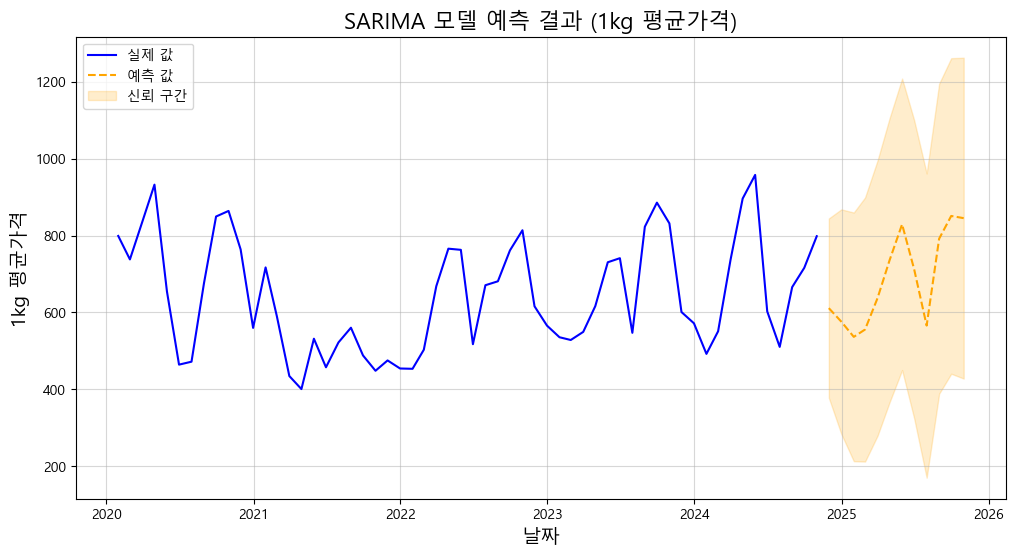

In [107]:
#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 6. 시각화
plt.figure(figsize=(12, 6))
plt.plot(price_series, label='실제 값', color='blue')  # 실제값
plt.plot(forecast_values.index, forecast_values, label='예측 값', color='orange', linestyle='--')  # 예측값
plt.fill_between(forecast_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='orange', alpha=0.2, label='신뢰 구간')  # 신뢰 구간
plt.title('SARIMA 모델 예측 결과 (1kg 평균가격)', fontsize=16)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('1kg 평균가격', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# sarimax 모델에 외생변수들 추가하여 진행
( 도매시장, 산지-광역시도, 기후데이터, 재배방식 )

재배방식은 각 재배방식의 수확기에서 3개월전까지의 기후데이터를 고려 ( 겨울은 6개월전까지 )

In [108]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

data = pd.read_csv("data-files/filtered_80_percent_confidence.csv")

# 날짜 변환 및 정렬
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.sort_values(by='DATE')

# 데이터 크기 최적화
data[['평균기온', '평균풍속', '평균강수량', '1kg_평균가격']] = data[
    ['평균기온', '평균풍속', '평균강수량', '1kg_평균가격']
].astype('float32')

# 2. 수확월 및 기후 데이터 설정
harvest_targets = {
    'Spring_6': [6],
    'Spring_7': [7],
    'Summer_9': [9],
    'Summer_8': [8],
    'Autumn_10': [10],
    'Autumn_11': [11],
    'Winter_3': [3],
    'Winter_4': [4],
}

# 수확월 기준 기후 데이터 집계
def aggregate_climate_data(data, harvest_targets):
    """
    수확월 기준으로 3개월(봄/여름/가을) 또는 6개월(겨울) 전 기후 데이터를 집계.
    """
    results = []
    for index, row in data.iterrows():
        target_month = row['DATE'].month
        target_date = row['DATE']
        
        # 수확월 기준 집계 기간 설정
        months_prior = 6 if target_month in [3, 4] else 3
        start_date = target_date - pd.DateOffset(months=months_prior)
        
        # 기간 필터링 및 평균 계산
        period_data = data[(data['DATE'] > start_date) & (data['DATE'] < target_date)]
        if not period_data.empty:
            aggregated = period_data[['평균기온', '평균풍속', '평균강수량']].mean()
            aggregated['DATE'] = target_date
            results.append(aggregated)
    
    return pd.DataFrame(results).reset_index(drop=True)

climate_aggregated = aggregate_climate_data(data, harvest_targets)

# 병합
final_model_data = data.merge(climate_aggregated, on='DATE', suffixes=('', '_aggregated'))


In [109]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv("data-files/filtered_80_percent_confidence.csv")

# 날짜 변환 및 정렬
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.sort_values(by='DATE')

# 데이터 크기 최적화
data[['평균기온', '평균풍속', '평균강수량', '1kg_평균가격']] = data[
    ['평균기온', '평균풍속', '평균강수량', '1kg_평균가격']
].astype('float32')

# 월별 데이터 처리
data['Month'] = data['DATE'].dt.month

# 이동 평균 집계 함수
def calculate_rolling_means(data, harvest_targets):
    # 복사본 생성
    df = data.copy()
    df.set_index('DATE', inplace=True)
    
    # 이동 평균 계산
    df['평균기온_aggregated'] = df['평균기온'].rolling('90D').mean()  # 3개월 평균
    df['평균풍속_aggregated'] = df['평균풍속'].rolling('90D').mean()
    df['평균강수량_aggregated'] = df['평균강수량'].rolling('90D').mean()

    # 6개월 평균 (겨울 수확만 적용)
    winter_months = [3, 4]
    df['평균기온_aggregated'] = np.where(
        df['Month'].isin(winter_months),
        df['평균기온'].rolling('180D').mean(),
        df['평균기온_aggregated']
    )
    df['평균풍속_aggregated'] = np.where(
        df['Month'].isin(winter_months),
        df['평균풍속'].rolling('180D').mean(),
        df['평균풍속_aggregated']
    )
    df['평균강수량_aggregated'] = np.where(
        df['Month'].isin(winter_months),
        df['평균강수량'].rolling('180D').mean(),
        df['평균강수량_aggregated']
    )
    
    df.reset_index(inplace=True)
    return df

# 이동 평균 데이터 계산
final_model_data = calculate_rolling_means(data, harvest_targets)


# 모델 학습

In [110]:
# 3. SARIMAX 모델 학습
target_variable = '1kg_평균가격'
exog_variables = ['평균기온_aggregated', '평균풍속_aggregated', '평균강수량_aggregated']

# 타겟 변수 및 외생 변수 설정
final_target_values = final_model_data[target_variable]
final_exog_data = final_model_data[exog_variables]

# SARIMAX 모델 구성
model = SARIMAX(
    final_target_values,
    exog=final_exog_data,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 3)  # 계절 주기 3개월
)
fit_model = model.fit(disp=False)

# 4. 성능 평가 및 결과 출력
predicted_values = fit_model.fittedvalues
actual_values = final_target_values

# 성능 지표 계산
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = mse ** 0.5
mape = (abs((actual_values - predicted_values) / actual_values).mean()) * 100

# 성능 출력
print({
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape,
})

{'MSE': np.float64(30805.19503142919), 'MAE': np.float64(138.2230777261148), 'RMSE': np.float64(175.5140878431962), 'MAPE': np.float64(23.62689046981835)}


# ETS 모델

In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 데이터 불러오기
data = pd.read_csv('D:/humanda/pjt-02/Mook/data-files/filtered_80_percent_confidence.csv')

# 1. 데이터 준비
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# 월별 평균값 계산 (1kg 평균가격)
monthly_price_series = data['1kg_평균가격'].resample('M').mean()

# 데이터 분할: 훈련 데이터와 테스트 데이터 (80%:20% 비율로 분리)
split_index = int(len(monthly_price_series) * 0.8)
train_data = monthly_price_series[:split_index]  # 훈련 데이터
test_data = monthly_price_series[split_index:]  # 테스트 데이터

# 훈련 데이터에 대해 ETS 모델 학습
ets_model_train = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12)
ets_result_train = ets_model_train.fit()

# 테스트 데이터에 대해 예측 수행
ets_test_forecast = ets_result_train.forecast(steps=len(test_data))

# 테스트 평가 지표 계산
ets_test_mae = mean_absolute_error(test_data.dropna(), ets_test_forecast)
ets_test_mse = mean_squared_error(test_data.dropna(), ets_test_forecast)
ets_test_mape = (np.abs((test_data.dropna() - ets_test_forecast) / test_data.dropna()) * 100).mean()
ets_test_r2 = r2_score(test_data.dropna(), ets_test_forecast)

# 테스트 평가 결과
ets_test_evaluation_results = {
    "Test MAE": ets_test_mae,      # 테스트 데이터 평균 절대 오차
    "Test MSE": ets_test_mse,    # 테스트 데이터 평균 제곱근 오차
    "Test MAPE (%)": ets_test_mape, # 테스트 데이터 평균 절대 백분율 오차
}

# 테스트 평가 결과 출력
print(ets_test_evaluation_results)


{'Test MAE': np.float64(139.12736521983348), 'Test MSE': np.float64(23233.239275504737), 'Test MAPE (%)': np.float64(22.608085408941232)}


C:\Users\human\AppData\Local\Temp\ipykernel_10568\657285089.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price_series = data['1kg_평균가격'].resample('M').mean()


# SARIMA, ETS 결과 비교

In [112]:
# SARIMA 결과와 ETS 결과 비교
comparison_results = {
    "SARIMA": evaluation_results,
    "ETS": ets_test_evaluation_results
}

comparison_results

{'SARIMA': {'MAE': np.float64(129.2941245841779),
  'RMSE': np.float64(174.18856569619103),
  'MAPE (%)': np.float64(21.24999572097166)},
 'ETS': {'Test MAE': np.float64(139.12736521983348),
  'Test MSE': np.float64(23233.239275504737),
  'Test MAPE (%)': np.float64(22.608085408941232)}}

# 분류 모델

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


# 수확 목표 월 및 계절 정의

In [114]:
# 수확 목표 월과 계절 정의
harvest_targets = {
    'Spring_6': [6],
    'Spring_7': [7],
    'Summer_9': [9],
    'Summer_8': [8],
    'Autumn_10': [10],
    'Autumn_11': [11],
    'Winter_3': [3],
    'Winter_4': [4],
}

seasons = {
    'Spring_6': [3, 4, 5],
    'Spring_7': [4, 5, 6],
    'Summer_9': [6, 7, 8],
    'Summer_8': [5, 6, 7],
    'Autumn_10': [7, 8, 9],
    'Autumn_11': [8, 9, 10],
    'Winter_3': [9, 10, 11],
    'Winter_4': [10, 11, 12],
}

# 데이터 필터링 및 그룹화

In [128]:
data = pd.read_csv("data-files/filtered_80_percent_confidence.csv")

grouped_data = []
for target, months in harvest_targets.items():
    season_months = seasons[target]
    if 'Winter' in target:  # 겨울의 경우 전년도 데이터 사용
        temp_data = data[data['Month'].isin(season_months)].copy()
        temp_data['Year'] = temp_data['Year'] + 1
        
        # 2020년도 겨울 데이터 제외
        temp_data = temp_data[temp_data['Year'] != 2020]
    else:
        temp_data = data[data['Month'].isin(season_months)].copy()
    
    # 도매시장과 산지-광역시도 기준 그룹화
    avg_prices = temp_data.groupby(['도매시장', '산지-광역시도'])['1kg_평균가격'].mean().reset_index()
    avg_prices['Target_Harvest_Month'] = target
    grouped_data.append(avg_prices)


In [129]:
avg_prices

,도매시장,산지-광역시도,1kg_평균가격,Target_Harvest_Month
0,강릉도매시장,강원도,646.104504,Winter_4
1,강릉도매시장,경기도,1087.797619,Winter_4
2,강릉도매시장,경상남도,618.750000,Winter_4
3,강릉도매시장,부산광역시,715.789474,Winter_4
4,강릉도매시장,서울특별시,885.462037,Winter_4
...,...,...,...,...
224,충주도매시장,충청북도,634.900247,Winter_4
225,포항도매시장,강원도,713.920247,Winter_4
226,포항도매시장,경상북도,680.193626,Winter_4
227,포항도매시장,부산광역시,421.674953,Winter_4


# 그룹화된 데이터 병합 및 타겟 변수 생성

In [130]:
# 데이터 병합
final_grouped_data = pd.concat(grouped_data, ignore_index=True)

merged_data = pd.merge(
    final_grouped_data,
    data[['도매시장', '산지-광역시도', '평균기온', '평균풍속', '평균강수량', 'Month', 'Year']],
    on=['도매시장', '산지-광역시도'],
    how='left'
)


# 평균 가격 기준으로 타겟 변수 생성
mean_price = merged_data['1kg_평균가격'].mean()
merged_data['Price_Label'] = merged_data['1kg_평균가격'].apply(lambda x: '비싸다' if x > mean_price else '싸다')

# 입력 피처 및 타겟 변수 준비

In [131]:
# 입력 피처 및 타겟 변수 설정
features = ['평균기온', '평균풍속', '평균강수량', '도매시장', '산지-광역시도']
target = 'Price_Label'

# 카테고리형 변수 인코딩
encoded_data = merged_data.copy()
label_encoders = {}
for col in ['도매시장', '산지-광역시도']:
    encoder = LabelEncoder()
    encoded_data[col] = encoder.fit_transform(encoded_data[col])
    label_encoders[col] = encoder

# 입력 및 타겟 분리
X = encoded_data[features]
y = encoded_data[target]

# 피처 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['평균기온', '평균풍속', '평균강수량']])
X[['평균기온', '평균풍속', '평균강수량']] = X_scaled

C:\Users\human\AppData\Local\Temp\ipykernel_10568\151240015.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['평균기온', '평균풍속', '평균강수량']] = X_scaled


# 데이터 분할 및 모델 정의

In [132]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 정의
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# 모델 학습 및 평가

In [133]:
# 모델 학습 및 평가
results_full = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 평가지표 계산
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results_full.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (비싸다)": report.get('비싸다', {}).get('precision', None),
        "Recall (비싸다)": report.get('비싸다', {}).get('recall', None),
        "F1-Score (비싸다)": report.get('비싸다', {}).get('f1-score', None),
        "Precision (싸다)": report.get('싸다', {}).get('precision', None),
        "Recall (싸다)": report.get('싸다', {}).get('recall', None),
        "F1-Score (싸다)": report.get('싸다', {}).get('f1-score', None)
    })

# 결과를 데이터프레임으로 정리
results_full_df = pd.DataFrame(results_full)

# 결과 출력
print(results_full_df)


                 Model  Accuracy  Precision (비싸다)  Recall (비싸다)  \
0  Logistic Regression  0.638548         0.620340      0.565534   
1        Decision Tree  0.707881         0.675513      0.710384   
2        Random Forest  0.707405         0.680642      0.693519   

   F1-Score (비싸다)  Precision (싸다)  Recall (싸다)  F1-Score (싸다)  
0         0.59167        0.651849     0.701513       0.675770  
1         0.69251        0.738603     0.705722       0.721788  
2         0.68702        0.731312     0.719380       0.725297  


# 도매시장과 광역시도를 고려하지 않고 분류 진행하였을때
성능이 조금 높아짐 아마 도매시장과 광역시도를 

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# 타겟 변수 생성
mean_price = data['1kg_평균가격'].mean()  # 전체 평균 계산
data['Price_Label'] = data['1kg_평균가격'].apply(lambda x: '비싸다' if x > mean_price else '싸다')  # 타겟 변수 생성

# 입력 피처에서 도매시장과 산지-광역시도를 제거
features = ['평균기온', '평균풍속', '평균강수량']  # 기후 데이터만 사용
target = 'Price_Label'

# 입력 및 타겟 분리
X = data[features]
y = data[target]

# 피처 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 모델 정의
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# 모델 학습 및 평가
results_full = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 평가지표 계산
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results_full.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (비싸다)": report.get('비싸다', {}).get('precision', None),
        "Recall (비싸다)": report.get('비싸다', {}).get('recall', None),
        "F1-Score (비싸다)": report.get('비싸다', {}).get('f1-score', None),
        "Precision (싸다)": report.get('싸다', {}).get('precision', None),
        "Recall (싸다)": report.get('싸다', {}).get('recall', None),
        "F1-Score (싸다)": report.get('싸다', {}).get('f1-score', None)
    })

# 결과를 데이터프레임으로 정리
results_full_df = pd.DataFrame(results_full)

# 결과 출력
print(results_full_df)


                 Model  Accuracy  Precision (비싸다)  Recall (비싸다)  \
0  Logistic Regression  0.564477         0.550336      0.112175   
1        Decision Tree  0.752129         0.712131      0.742818   
2        Random Forest  0.753041         0.717828      0.732558   

   F1-Score (비싸다)  Precision (싸다)  Recall (싸다)  F1-Score (싸다)  
0        0.186364        0.565886     0.926616       0.702658  
1        0.727151        0.786727     0.759584       0.772917  
2        0.725118        0.782294     0.769441       0.775814  
